In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import torch
import dgl
import random
import networkx as nx
import numpy as np

from tqdm import tqdm
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from PIL import Image

from data.zinc import mol2graph, Library, ZINC250K
from data.qm9 import QM9


from models.network import CVAEF

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

DEVICE = torch.device('cpu')

random.seed(0)

In [3]:
atom_list = [i for i in Library.atom_list]
atom_list.append('END')

bondtype_list  = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC
]

chirality_list = [
    Chem.rdchem.BondStereo.STEREONONE, 
    Chem.rdchem.BondStereo.STEREOANY,
    Chem.rdchem.BondStereo.STEREOZ,
    Chem.rdchem.BondStereo.STEREOE
]

In [21]:
dataset = ZINC250K('/home/dawood/Datasets/ZINC250K/data.csv')
#dataset = QM9('/home/dawood/Datasets/QM9/data.txt')

In [5]:
#state_dict = torch.load('/home/dawood/Experiments/compound-gan-c7f57372210a4de2a2af310e75c54d4f/model_76.weights', map_location='cpu')#
#state_dict = torch.load('/home/dawood/Experiments/compound-gan-0f740abcf5244a9d91ad75689c747fcb/model_177.weights', map_location='cpu')#
state_dict = torch.load('./model.weights', map_location='cpu')#.weights')
print(state_dict['epoch'], state_dict['seq_len'])
seq_len = state_dict['seq_len']
seq_len = 64 if seq_len == np.inf else seq_len

2 inf


In [11]:
atom_feats = [43, 7, 3, 3]
bond_feats = [5, 2, 4]
D = 128
model = CVAEF(atom_feats, bond_feats, D,
              [D, D, D, D], 1, 0.9, True, use_adjoint=False, num_decoder_layers=4)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(DEVICE)

In [17]:
def run(smiles, deterministic=False):
    
    if len(smiles) > 0:
        mol = Chem.MolFromSmiles(smiles)
        G = mol2graph(mol)[0]
        G.to(DEVICE)
        
        mu, var = model.encoder(G)
        if not deterministic:
            z = model.reparameterize(mu, var).unsqueeze(0)
        else:
            z = mu.unsqueeze(0)
    else:
        z = torch.zeros((32, D))
        logP = torch.zeros((32, 1))
        for i in range(len(z)):
            z[i].normal_(0, 1)# = torch.randn(128)
            logP[i].uniform_(0, 1)
            logP[i] = logP[i] * 4 - 1
        #z = z.to(torch.device('cuda:0'))
        z = model.cnf(z, logP, None, True)[0]
    
    G = model.decoder.generate(z, seq_len)
    
    atoms = [atom_list[i] for i in G.ndata['feats'][:, :43].argmax(1).data.cpu()]
    aromatic = [i.item() for i in G.ndata['feats'][:, -2:].argmax(1).data.cpu()]

    G_pred = nx.Graph()
    num_nodes = list(G.batch_num_nodes)
    aid = 0
    cid = 0
    for i, atom in enumerate(atoms):
        G_pred.add_node(i, atom='%s'%(atom), atom_id='%d'%(aid), compound_id=cid)
        aid += 1
        if aid == num_nodes[0]:
            cid += 10
            cid = cid % 255
            num_nodes.pop(0)
            aid = 0

    edge_pred = G.edata['feats'][:, :5].argmax(1).data.cpu()
    edge_pred_score = G.edata['feats'][:, :5].max(1)[0].data.cpu()

    edges = []
    edge_types = []

    edge_start = [i.item() for i in G.edges()[0]]
    edge_end = [i.item() for i in G.edges()[1]]
    edge_num = 0
    for i,j in zip(edge_start, edge_end):
        if (i == j): 
            edge_num += 1
            continue
        
        if edge_pred[edge_num] > 0:
            edges.append((i, j))
            edge_types.append(edge_pred[edge_num].item())
            
        edge_num += 1

    for i in range(len(edges)):
        G_pred.add_edge(*edges[i], bond_type=edge_types[i])
        
    for i, a in enumerate(atoms):
        if a == 'END':
            G_pred.remove_node(i)

    
    pos = nx.drawing.nx_agraph.graphviz_layout(G_pred)

    node_labels = nx.get_node_attributes(G_pred, 'atom')
    edge_labels = nx.get_edge_attributes(G_pred, 'bond_type')
    cids = nx.get_node_attributes(G_pred, 'compound_id')
    edge_color_map = {
        0: 'm',
        1: '0',
        2: 'r',
        3: 'g',
        4: 'y'
    }
    
    node_color_map = defaultdict(lambda: '0')
    node_color_map['N'] = 'blue'
    node_color_map['O'] = 'red'
    node_color_map['S'] = 'yellow'
        
    edge_colors = [edge_color_map[v] for k,v in edge_labels.items()]
    node_colors = [node_color_map[v] for k, v in node_labels.items()] # v for k, v in cids.items()]
    nx.draw_networkx(G_pred, pos, font_color='w', font_size=10, font_weight='bold',
                     node_size=256, labels=node_labels, node_color=node_colors,
                     edge_color=edge_colors, width=2, cmap=plt.cm.Set1)
    
    node_labels = nx.get_node_attributes(G_pred, 'atom_id')
    for k in node_labels:
        node_labels[k] = '%10s'%node_labels[k]
    new_pos = {}
    for k, (x, y) in pos.items():
        new_pos[k] = (x, y)
    nx.draw_networkx_labels(G_pred, new_pos, labels=node_labels, font_size=10, font_weight='bold',)

In [18]:
def graph2mol(G):
    
    s = 0
    node_list = []
    for i in atom_feats:
        node_list.append(G.ndata['feats'][:, s:s+i].argmax(-1, keepdim=True).data.cpu())
        s += i
    node_list = torch.cat(node_list, -1)

    s = 0
    edge_list = []
    for i in bond_feats:
        edge_list.append(G.edata['feats'][:, s:s+i].argmax(-1, keepdim=True).data.cpu())
        s += i
    edge_list = torch.cat(edge_list, -1)

    
    nodes = []
    edges = []
    
    idx_map = {}
    end_node_idx = -1
    
    pred_mol = Chem.RWMol()
        
    for i, node in enumerate(node_list):
        if node[0].item() == len(Library.atom_list):
            end_node_idx = i
            continue
            
        atom_id  = Library.atom_list[node[0].item()]
        charge   = Library.charge_list[node[1].item()]
        electron = Library.electron_list[node[2].item()]
        try:
            chirality = Library.chirality_list[node[3].item()]
        except IndexError:
            chirality = ''
        
        a = Chem.Atom(atom_id)
        
        if chirality=='R': 
            a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
        elif chirality=='S': 
            a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
            
        a.SetFormalCharge(charge)
        a.SetNumRadicalElectrons(electron)

        idx = pred_mol.AddAtom(a)
        idx_map[i] = idx
        
        nodes.append(atom_id)

        
    edge_start = [i.item() for i in G.edges()[0]]
    edge_end   = [i.item() for i in G.edges()[1]]
    
    edge_num   = 0
    for i,j in zip(edge_start, edge_end):
        
        if i == end_node_idx or j == end_node_idx:
            edge_num += 1
            continue
            
        assert i != j, 'Investigate'
        
        edge       = edge_list[edge_num]
        bond_type  = edge[0].item()
        conjugated = edge[1].item()
        chirality  = edge[2].item()

        if bond_type == 0:
            edge_num += 1
            continue
            
        bond_type = bondtype_list[bond_type - 1]
        bond = pred_mol.AddBond(idx_map[i], idx_map[j], bond_type)
        bond = pred_mol.GetBondWithIdx(bond - 1)
        bond.SetStereo(chirality_list[chirality])
        bond.SetIsConjugated(conjugated)
                
        edge_num += 1
                
        edges.append(((j, i), bond_type))
        
    return pred_mol

def reconstruct(smiles, draw=True, deterministic=False, seq_len=100):
    
    mol = Chem.MolFromSmiles(smiles)
    G = mol2graph(mol)[0]
    G.to(DEVICE)
        
    mu, var = model.encoder(G)
    if not deterministic:
        z = model.reparameterize(mu, var).unsqueeze(0)
    else:
        z = mu.unsqueeze(0)
            
    G = model.decoder.generate(z, seq_len)

    pred_mol = graph2mol(G)
    
    fp_gt   = FingerprintMols.FingerprintMol(mol)
    fp_pred = FingerprintMols.FingerprintMol(pred_mol)
    similarity = DataStructs.FingerprintSimilarity(fp_gt, fp_pred)
    
    try:
        Chem.SanitizeMol(pred_mol, catchErrors=False)
        valid = 1
    except Exception as e:
        print(e)
        valid = 0
      
    if draw:
        try:
            img = Draw.MolsToGridImage([mol, pred_mol], molsPerRow=2, subImgSize=(400, 400), legends=['GT', 'Pred'])
            plt.figure(figsize=(8, 8))
            plt.imshow(img, interpolation='bilinear')
        except Exception as e:
            Draw.MolToMPL(mol, size=(250, 250)); 
            
        plt.axis('off')
        plt.show()
    
    return z, valid, similarity#edge_list, node_list, z, valid, similarity

def generate_random(num_mols, draw=True):
    
    pred_mols = []
    
    for i in tqdm(range(num_mols//32)):
        z = torch.zeros((32, 256))
        for i in range(len(z)):
            z[i].normal_(0, 1)
        z = z.to(DEVICE)
        z = model.cnf(z, None, None, True)[0]

        G = model.decoder.generate(z, seq_len)
        G = dgl.unbatch(G)

        pred_mols += [graph2mol(g) for g in G]
    
    valid_mols = []
    valids = 0
    for mol in pred_mols:
        try:
            Chem.SanitizeMol(mol, catchErrors=False)
            valids += 1
            valid_mols.append(mol)
        except Exception as e:
            #print(e)
            pass
    
    if draw:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(400, 400))

        num_mols = len(valid_mols)
        plt.figure(figsize=(num_mols*2, num_mols*2))
        plt.imshow(img, interpolation='bilinear')

        plt.axis('off')
        plt.show()
    
    return valids

In [14]:
generate_random(32)

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: size mismatch, m1: [32 x 1], m2: [2 x 128] at /opt/conda/conda-bld/pytorch_1570710718161/work/aten/src/TH/generic/THTensorMath.cpp:197

Sanitization error: Explicit valence for atom # 32 C, 7, is greater than permitted


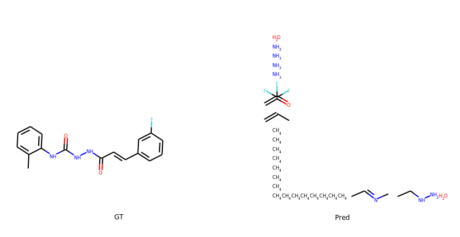

Sanitization error: Explicit valence for atom # 29 N, 4, is greater than permitted


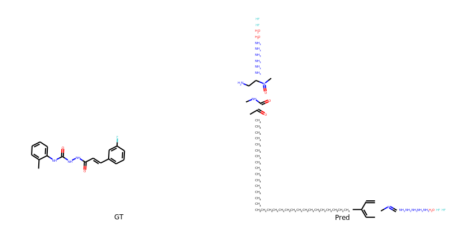

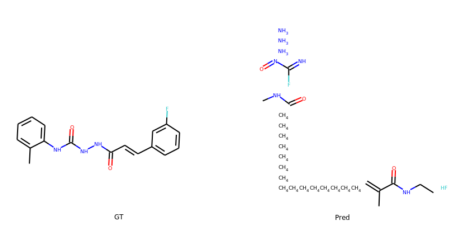

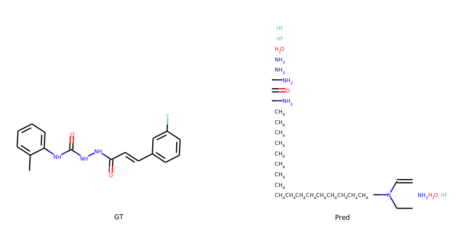

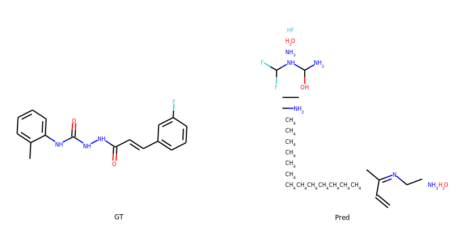

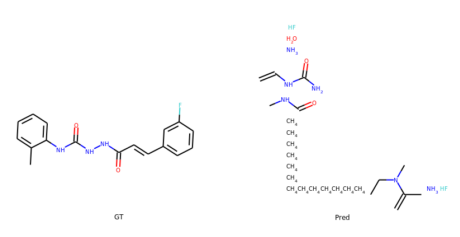

Sanitization error: Explicit valence for atom # 1 C, 5, is greater than permitted


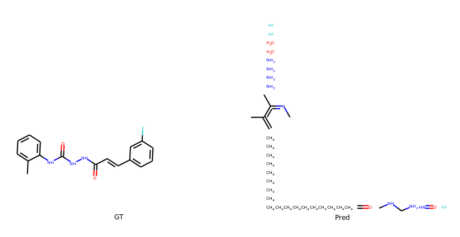

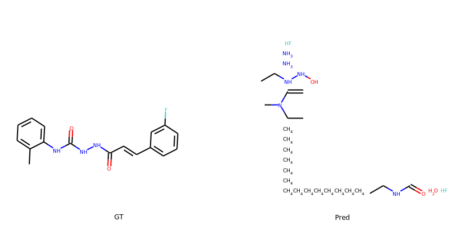

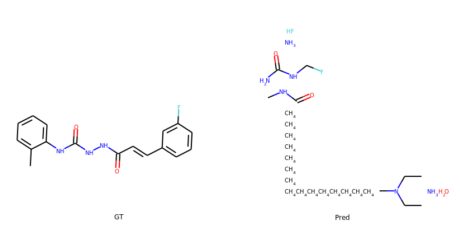

Sanitization error: Explicit valence for atom # 3 C, 5, is greater than permitted


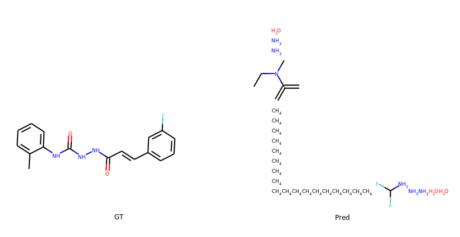

[0, 0, 1, 1, 1, 1, 0, 1, 1, 0] [0.3125, 0.3828125, 0.350210970464135, 0.3125, 0.4765625, 0.375, 0.3671875, 0.46875, 0.46875, 0.453125]
0.6 0.3967398470464135


In [22]:
idx = torch.randint(len(dataset), (1,))
smiles = dataset.data[idx]

valids = []
scores = []
for i in range(10):
    z, v, s = reconstruct(smiles)
    valids.append(v)
    scores.append(s)
    
print(valids, scores)
print(torch.tensor(valids, dtype=float).mean().item(), torch.tensor(scores, dtype=float).mean().item())

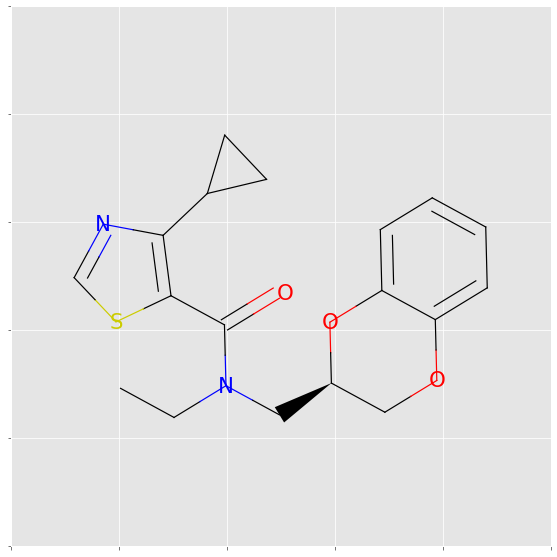

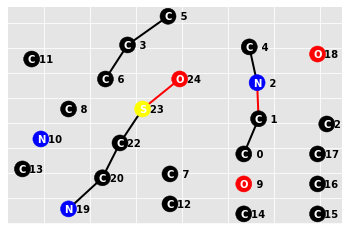

In [24]:
idx = torch.randint(0, len(dataset), (1,))
#idx = 20
smiles = dataset.data[idx]
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#edge_list, node_list, emb, valid, similarity = run_network(smiles)
G = run(smiles)

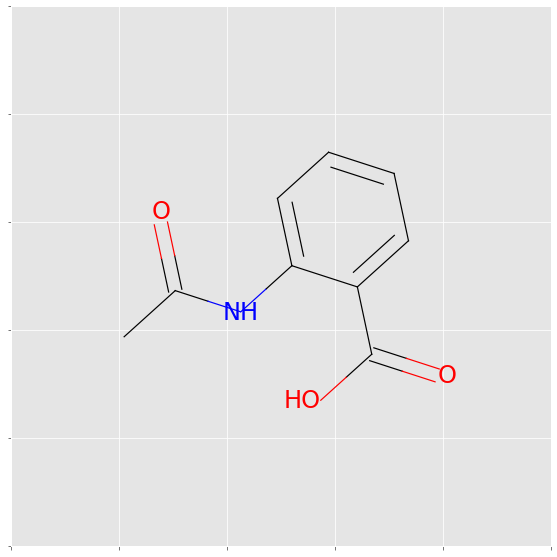

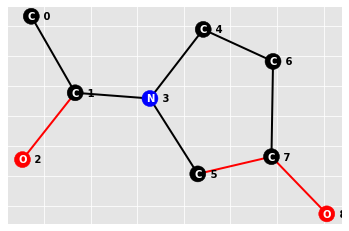

In [36]:
#smiles = 'C(=O)C=CCC=C'
#smiles = 'C'
smiles='CC(=O)NC1=CC=CC=C1C(=O)O'
#reconstruct(smiles)
# smiles='C1=CC=C(C(=C1)C(=O)OC2=CC=CC=C2C(=O)O)O'
# smiles='CCC[NH2+]C1CCC(O)(Cc2nc(C)cs2)CC1'
# smiles='C#CCOCC1CCN(C(=O)c2ccc(S(=O)(=O)N3CCCC[C@H]3C)cc2)CC1'
# smiles='Cc1cccc2sc(NC(=O)[C@H](C)N3C(=O)[C@@H]4CC=CC[C@H]4C3=O)nc12'
# smiles='Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1'
# smiles='CCOc1ccc2nc(N(C[C@@H]3CCCO3)C(=O)c3ccccc3S(C)(=O)=O)sc2c1'
# smiles='COc1cc(C(=O)N(Cc2cccc(F)c2)[C@H]2CCS(=O)(=O)C2)cc(OC)c1OC'
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#G = mol2graph(mol)[0]
#G.to(DEVICE)
#mu, var = enc(G)
run(smiles)

In [ ]:
mol